In [1]:
from dataset import Places205Dataset
from train import Trainer
from models import Generator, Discriminator, Classifier
from losses import GeneratorCriterion, DiscriminatorCriterion
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, RandomApply, ToTensor
from utils import GaussianNoise
from torch.utils.data import DataLoader
import random
import os
import numpy as np
import torch
from torchinfo import summary
from torchview import draw_graph
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from matplotlib import pyplot as plt


C:\Users\loren\anaconda3\envs\torch\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
## RUN PARAMETERS ##

DATASET_ROOT = 'C:\\Users\\loren\\Datasets\\Places205'
DATASET_INFO_FILE = 'files_split.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metrics = [FrechetInceptionDistance(normalize=True, compute_on_cpu=True).to(device), # inputs in [0, 1] range
           StructuralSimilarityIndexMeasure(data_range=1.0, compute_on_cpu=True).to(device),
           PeakSignalNoiseRatio(data_range=1.0, compute_on_cpu=True).to(device),
           LearnedPerceptualImagePatchSimilarity(net_type='vgg', normalize=True, compute_on_cpu=True).to(device)] # inputs in [0, 1] range

BATCH_SIZE = 8
NUM_WORKERS = 4

ENABLE_CLASSIFIER = True # whether to use classifier in generator

IMG_SIZE = 256
USE_LAB_COLORSPACE = True # whether to use LAB color space or RGB
L1_LAMBDA = 100 # li loss coefficient
L2_LAMBDA = 0 # l2 loss coefficient (color loss)
CLASS_LAMBDA = 0.01 if ENABLE_CLASSIFIER else 0 # classifier loss coefficient
LABEL_SMOOTHING = 0.9 # true labels for the discriminator are 1, but we smooth them to 0.9
WGAN = False # whether to use Wasserstein loss
WGAN_GP = False # whether to use Wasserstein loss with gradient penalty
N_CRITIC = 1 if (not WGAN or WGAN_GP) else 5 # number of iteration of critic training
CLIP_WEIGHTS = WGAN and not WGAN_GP # whether to clip critic weights when using Wasserstein loss
CLIP_VALUE = 0.01 # max abs value for critic weights

DISCRIMINATOR_TYPE = 'patch_gan' # either DCGAN or patch_gan
PIXEL_CNN = False # use pixel CNN for decoder in generator or standard U-net Architecture
USE_INSTANCE_NORM = True if BATCH_SIZE==1 else False # norm layer type in models
GEN_IN_CHANNEL = 1 # always 1 channel for grayscale imgs
GEN_OUT_CHANNEL = 2 if USE_LAB_COLORSPACE else 3 # reconstruct only ab channels for Lab images,
DISC_IN_CHANNEL = GEN_IN_CHANNEL + GEN_OUT_CHANNEL # discriminator take both input and output images
NUM_CLASSES = 205 # number of classes in dataset
FREEZE_FEATURES = False # whether to freeze features extractor in classifier

if ENABLE_CLASSIFIER:
    metrics.append(MulticlassAccuracy(num_classes=NUM_CLASSES, compute_on_cpu=True).to(device))

# options for Trainer object
options = {
    'checkpoint_path': './test.tar', # checkpoint file
    'use_lab_colorspace' : USE_LAB_COLORSPACE,
    'reset_training': True, # whether to reset or resuming training
    'num_epochs': 50,
    'clip_weights': CLIP_WEIGHTS,
    'clip_value': CLIP_VALUE,
    'n_critic': N_CRITIC,
    'output_path': './gan_imgs', # where to store generated images
    'plot_every_nstep': 10_000//BATCH_SIZE,
    'log_every_nstep': 10 if BATCH_SIZE == 1 else 1,
    'verbose': False, # whether to print info to console
    'tensorboard_path': 'default', # where to store tensorboard logs, None to disable tensorboard
}

os.system('mkdir {}'.format(options['output_path']))

1

In [3]:
## SET SEEDS ##

SEED = 123456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ':4096:8'


# Dataset creation

## Define transformations to apply to each dataset input and output

In [4]:
# transformation to apply to each input image, ToTensor() and Resize() are mandatory for all datasets
transforms_train = Compose([ToTensor(), Resize((IMG_SIZE, IMG_SIZE)), RandomHorizontalFlip()]) #, RandomVerticalFlip(), RandomApply([GaussianNoise(mean=0.0, std=0.1)], p=0.2)])
transforms_val = Compose([ToTensor(), Resize((IMG_SIZE, IMG_SIZE))])
transforms_test = Compose([ToTensor(), Resize((IMG_SIZE, IMG_SIZE))])


## Get dataset objects from helper function

In [5]:
train_dataset = Places205Dataset(dataset_folder=DATASET_ROOT, dataset_info_file=DATASET_INFO_FILE,
                                 dataset_split='train', transforms=transforms_train,
                                 use_lab_colorspace=USE_LAB_COLORSPACE)

val_dataset = Places205Dataset(dataset_folder=DATASET_ROOT, dataset_info_file=DATASET_INFO_FILE,
                               dataset_split='val', transforms=transforms_val,
                               use_lab_colorspace=USE_LAB_COLORSPACE)

test_dataset = Places205Dataset(dataset_folder=DATASET_ROOT, dataset_info_file=DATASET_INFO_FILE,
                                dataset_split='test', transforms=transforms_test,
                                use_lab_colorspace=USE_LAB_COLORSPACE)


## Define corresponding dataloaders

In [6]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                              pin_memory=True, persistent_workers=True, drop_last=(1 <= len(train_dataset)%BATCH_SIZE <= 8))

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                            pin_memory=True, persistent_workers=True, drop_last=(1 <= len(val_dataset)%BATCH_SIZE <= 8))

test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                             pin_memory=True, persistent_workers=True)


# Models Definition

### Generator

In [7]:
generator = Generator(use_instance_norm=USE_INSTANCE_NORM, in_channels=GEN_IN_CHANNEL, out_channels=GEN_OUT_CHANNEL, use_pixelTCL=PIXEL_CNN, classifier_branch=ENABLE_CLASSIFIER, num_classes=NUM_CLASSES)
generator.to(device)
print(summary(generator, input_size=(BATCH_SIZE, GEN_IN_CHANNEL, IMG_SIZE, IMG_SIZE), depth=5))


C:\Users\loren\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     [8, 2, 256, 256]          --
├─ModuleList: 1-1                             --                        --
│    └─EncoderBlock: 2-1                      [8, 64, 128, 128]         --
│    │    └─Sequential: 3-1                   [8, 64, 128, 128]         --
│    │    │    └─Conv2d: 4-1                  [8, 64, 128, 128]         1,024
│    │    │    └─LeakyReLU: 4-2               [8, 64, 128, 128]         --
│    └─EncoderBlock: 2-2                      [8, 128, 64, 64]          --
│    │    └─Sequential: 3-2                   [8, 128, 64, 64]          --
│    │    │    └─Conv2d: 4-3                  [8, 128, 64, 64]          131,072
│    │    │    └─BatchNorm2d: 4-4             [8, 128, 64, 64]          256
│    │    │    └─LeakyReLU: 4-5               [8, 128, 64, 64]          --
│    └─EncoderBlock: 2-3                      [8, 256, 32, 32]          --
│    │    └


(process:32828): Pango-WARNING **: 18:58:40.535: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


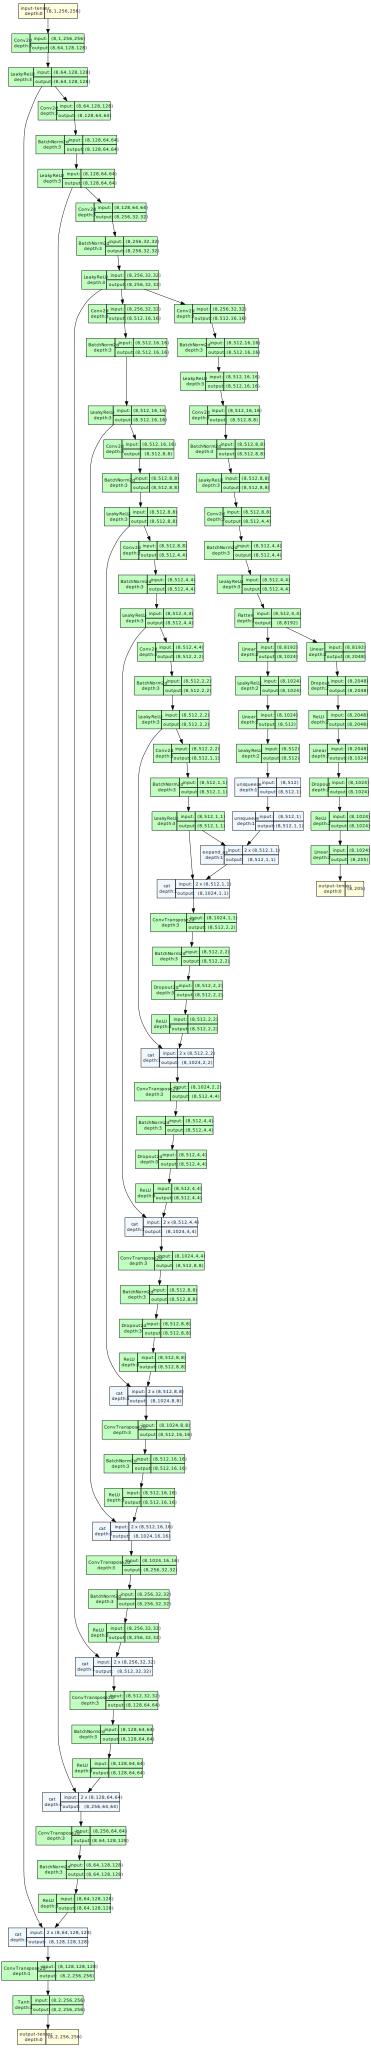

In [8]:
generator_graph = draw_graph(generator, input_size=(BATCH_SIZE, GEN_IN_CHANNEL, IMG_SIZE, IMG_SIZE))
generator_graph.visual_graph

## Classifier

In [9]:
# if ENABLE_CLASSIFIER:
#     classifier = Classifier(n_classes=NUM_CLASSES, freeze_features=FREEZE_FEATURES)
#     classifier.to(device)
#     print(summary(classifier, input_size=(BATCH_SIZE, DISC_IN_CHANNEL, IMG_SIZE, IMG_SIZE), depth=4))
# else:
#     classifier = None

In [10]:
# if ENABLE_CLASSIFIER:
#     classifier_graph = draw_graph(classifier, input_size=(BATCH_SIZE, DISC_IN_CHANNEL, IMG_SIZE, IMG_SIZE))
# classifier_graph.visual_graph if ENABLE_CLASSIFIER else None

## Discriminator

In [11]:
discriminator = Discriminator(use_instance_norm=USE_INSTANCE_NORM, in_channels=DISC_IN_CHANNEL, disable_norm=WGAN_GP, network_type=DISCRIMINATOR_TYPE)
discriminator.to(device)
print(summary(discriminator, input_size=(BATCH_SIZE, DISC_IN_CHANNEL, IMG_SIZE, IMG_SIZE), depth=4))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [8, 1, 30, 30]            --
├─ModuleList: 1-1                        --                        --
│    └─EncoderBlock: 2-1                 [8, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [8, 64, 128, 128]         --
│    │    │    └─Conv2d: 4-1             [8, 64, 128, 128]         3,072
│    │    │    └─LeakyReLU: 4-2          [8, 64, 128, 128]         --
│    └─EncoderBlock: 2-2                 [8, 128, 64, 64]          --
│    │    └─Sequential: 3-2              [8, 128, 64, 64]          --
│    │    │    └─Conv2d: 4-3             [8, 128, 64, 64]          131,072
│    │    │    └─BatchNorm2d: 4-4        [8, 128, 64, 64]          256
│    │    │    └─LeakyReLU: 4-5          [8, 128, 64, 64]          --
│    └─EncoderBlock: 2-3                 [8, 256, 32, 32]          --
│    │    └─Sequential: 3-3              [8, 256, 32, 32]          --
│    │


(process:24636): Pango-WARNING **: 18:58:40.820: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


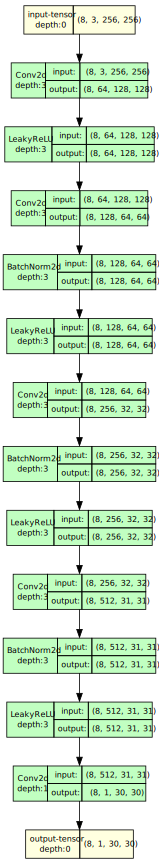

In [12]:
discriminator_graph = draw_graph(discriminator, input_size=(BATCH_SIZE, DISC_IN_CHANNEL, IMG_SIZE, IMG_SIZE))
discriminator_graph.visual_graph

## Define Losses

In [13]:
disc_criterion = DiscriminatorCriterion(device=device, wgan=WGAN, wgan_gp=WGAN_GP, label_smoothing_value=LABEL_SMOOTHING)

In [14]:
gen_criterion = GeneratorCriterion(device=device, l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA, wgan=WGAN, class_lambda=CLASS_LAMBDA)

## Define Optimizers

In [15]:
if WGAN and not WGAN_GP: # wgan with clipping
    gen_opt = torch.optim.RMSprop(generator.parameters(), lr=5e-5)
    disc_opt = torch.optim.RMSprop(discriminator.parameters(), lr=5e-5)
else: # gan or wgan gp
    gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    disc_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

## Lr Scheduler

In [16]:
gen_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(gen_opt, T_max=options['num_epochs'], eta_min=2e-6)
disc_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(disc_opt, T_max=options['num_epochs'], eta_min=2e-6)
# gen_lr_scheduler = None
# disc_lr_scheduler = None

# Training

In [17]:
trainer = Trainer(generator=generator, discriminator=discriminator,
                  gen_optimizer=gen_opt, disc_optimizer=disc_opt,
                  gen_scheduler=gen_lr_scheduler, disc_scheduler=disc_lr_scheduler,
                  gen_criterion=gen_criterion, disc_criterion=disc_criterion,
                  train_loader=train_dataloader, val_loader=val_dataloader,
                  device=device, metrics=metrics, options=options)


No checkpoint found at ./test.tar
Starting from scratch


In [ ]:
trainer.train()




Epoch 1/50
Training...


  0%|          | 121/25284 [00:31<1:49:12,  3.84it/s]


In [ ]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_gen_loss_gan'])
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['val_gen_loss_gan'])
plt.legend(['train', 'val'])

In [ ]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_gen_loss_recon'])
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['val_gen_loss_recon'])
plt.legend(['train', 'val'])

In [ ]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_disc_loss'])
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['val_disc_loss'])

In [ ]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_gen_class_loss'])
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['val_gen_class_loss'])

In [ ]:
for metric in metrics:
    name = metric._get_name().lower()
    data_val = trainer.history['val_'+name]
    plt.plot(range(1, 1+trainer.history['elapsed_epochs']), data_val)
    plt.title(name)
    plt.show()